In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from transformers import ViTModel, ViTConfig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from tqdm import tqdm


Эксперимент: сравнение лоссов на CIFAR-10

- Датасет: CIFAR-10 (10 классов)
- Модель: ViT-Tiny
- Лоссы: CE, CE+NeuralNDCG (α=0.5), CE+NeuralNDCG (α=0.3)

NeuralNDCG: ранжирование через softmax, оптимизация DCG/IDCG для top-k

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NeuralNDCG(nn.Module):
    """NDCG loss для ранжирования предсказаний"""
    def __init__(self, temp=1.0):
        super().__init__()
        self.temp = temp

    def forward(self, logits, targets):
        probs = F.softmax(logits / self.temp, dim=1)
        ranks = torch.argsort(torch.argsort(probs, dim=1, descending=True), dim=1) + 1
        target_ranks = ranks.gather(1, targets.unsqueeze(1)).squeeze(1)

        dcg = 1.0 / torch.log2(target_ranks.float() + 1)
        idcg = 1.0 / torch.log2(torch.tensor(2.0, device=logits.device))

        return 1.0 - (dcg / idcg).mean()

class CombinedLoss(nn.Module):
    """Комбинированный лосс: CE + NeuralNDCG"""
    def __init__(self, alpha=0.5, temp=1.0):
        super().__init__()
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
        self.ndcg = NeuralNDCG(temp)

    def forward(self, logits, targets):
        ce_val = self.ce(logits, targets)
        ndcg_val = self.ndcg(logits, targets)
        total = self.alpha * ce_val + (1 - self.alpha) * ndcg_val
        return total, ce_val, ndcg_val

class ViTClassifier(nn.Module):
    """ViT классификатор для CIFAR-10"""
    def __init__(self, num_classes=10, model_size='tiny'):
        super().__init__()

        if model_size == 'tiny':
            config = ViTConfig(
                image_size=32, patch_size=4, num_channels=3,
                hidden_size=192, num_hidden_layers=6,
                num_attention_heads=3, intermediate_size=768
            )
        else:
            config = ViTConfig(
                image_size=32, patch_size=4, num_channels=3,
                hidden_size=384, num_hidden_layers=8,
                num_attention_heads=6, intermediate_size=1536
            )

        self.vit = ViTModel(config)
        self.head = nn.Sequential(
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(0.1),
            nn.Linear(config.hidden_size, num_classes)
        )

    def forward(self, x):
        out = self.vit(pixel_values=x)
        cls_token = out.last_hidden_state[:, 0]
        return self.head(cls_token)


In [3]:

def get_dataloaders(batch_size=128):
    """Загрузка CIFAR-10 с аугментациями"""
    mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_ds = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_ds = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def train_epoch(model, loader, criterion, optimizer, device):
    """Одна эпоха обучения"""
    model.train()
    losses = {'total': 0, 'ce': 0, 'ndcg': 0}
    is_combined = isinstance(criterion, CombinedLoss)

    for img, lbl in tqdm(loader, leave=False):
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()

        logits = model(img)
        if is_combined:
            loss, ce, ndcg = criterion(logits, lbl)
            losses['ce'] += ce.item()
            losses['ndcg'] += ndcg.item()
        else:
            loss = criterion(logits, lbl)

        loss.backward()
        optimizer.step()
        losses['total'] += loss.item()

    n = len(loader)
    return losses['total'] / n, losses['ce'] / n if is_combined else 0, losses['ndcg'] / n if is_combined else 0

def evaluate(model, loader, device):
    """Оценка модели на тестовом наборе"""
    model.eval()
    preds, labels, probs = [], [], []

    with torch.no_grad():
        for img, lbl in loader:
            logits = model(img.to(device))
            prob = F.softmax(logits, dim=1)

            probs.append(prob.cpu().numpy())
            preds.append(logits.argmax(1).cpu().numpy())
            labels.append(lbl.numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    probs = np.concatenate(probs)

    return (
        accuracy_score(labels, preds),
        top_k_accuracy_score(labels, probs, k=3),
        top_k_accuracy_score(labels, probs, k=5)
    )

def run_experiment(loss_type='ce', epochs=30, alpha=0.5):
    """Запуск эксперимента с заданным лоссом"""
    train_loader, test_loader = get_dataloaders(batch_size=128)
    model = ViTClassifier(num_classes=10, model_size='tiny').to(device)

    if loss_type == 'combined':
        criterion = CombinedLoss(alpha=alpha)
    elif loss_type == 'ndcg':
        criterion = NeuralNDCG()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {
        'train_loss': [], 'train_ce': [], 'train_ndcg': [],
        'test_acc': [], 'test_top3': [], 'test_top5': []
    }

    for epoch in range(epochs):
        loss, ce, ndcg = train_epoch(model, train_loader, criterion, optimizer, device)
        acc, top3, top5 = evaluate(model, test_loader, device)
        scheduler.step()

        history['train_loss'].append(loss)
        history['train_ce'].append(ce)
        history['train_ndcg'].append(ndcg)
        history['test_acc'].append(acc)
        history['test_top3'].append(top3)
        history['test_top5'].append(top5)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | "
              f"Acc: {acc:.4f} | Top-3: {top3:.4f} | Top-5: {top5:.4f}")

    return model, history



In [4]:

def plot_results(results_dict):
    """Визуализация результатов экспериментов"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    titles = ['Training Loss', 'Test Accuracy (Top-1)', 'Top-3 Accuracy', 'Top-5 Accuracy']
    keys = [('train_loss', 0, 0), ('test_acc', 0, 1), ('test_top3', 1, 0), ('test_top5', 1, 1)]

    for name, hist in results_dict.items():
        for key, i, j in keys:
            axes[i, j].plot(hist[key], label=name)

    for idx, (key, i, j) in enumerate(keys):
        axes[i, j].set_title(titles[idx])
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].set_ylabel('Value')
        axes[i, j].legend()
        axes[i, j].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ndcg_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_summary_table(results_dict):
    """Вывод итоговой таблицы результатов"""
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"{'Model':<25} {'Top-1':<10} {'Top-3':<10} {'Top-5':<10} {'Loss':<10}")
    print("-"*80)

    for name, hist in results_dict.items():
        print(f"{name:<25} {hist['test_acc'][-1]:<10.4f} "
              f"{hist['test_top3'][-1]:<10.4f} {hist['test_top5'][-1]:<10.4f} "
              f"{hist['train_loss'][-1]:<10.4f}")

    print("="*80)


[1/3] CE only...


100%|██████████| 170M/170M [00:18<00:00, 9.15MB/s]


Epoch 1/6 | Loss: 1.9341 | Acc: 0.3192 | Top-3: 0.6862 | Top-5: 0.8490


Epoch 2/6 | Loss: 1.7055 | Acc: 0.4089 | Top-3: 0.7502 | Top-5: 0.8948


Epoch 3/6 | Loss: 1.5738 | Acc: 0.4453 | Top-3: 0.7867 | Top-5: 0.9213


Epoch 4/6 | Loss: 1.4606 | Acc: 0.4818 | Top-3: 0.8157 | Top-5: 0.9288


Epoch 5/6 | Loss: 1.3670 | Acc: 0.5263 | Top-3: 0.8450 | Top-5: 0.9422


Epoch 6/6 | Loss: 1.2998 | Acc: 0.5336 | Top-3: 0.8481 | Top-5: 0.9457

[2/3] CE + NeuralNDCG (α=0.5)...


Epoch 1/6 | Loss: 1.1569 | Acc: 0.3588 | Top-3: 0.7307 | Top-5: 0.8827


Epoch 2/6 | Loss: 1.0110 | Acc: 0.4072 | Top-3: 0.7491 | Top-5: 0.8864


Epoch 3/6 | Loss: 0.9225 | Acc: 0.4431 | Top-3: 0.7862 | Top-5: 0.9170


Epoch 4/6 | Loss: 0.8535 | Acc: 0.5055 | Top-3: 0.8305 | Top-5: 0.9389


Epoch 5/6 | Loss: 0.8016 | Acc: 0.5190 | Top-3: 0.8406 | Top-5: 0.9436


Epoch 6/6 | Loss: 0.7590 | Acc: 0.5410 | Top-3: 0.8528 | Top-5: 0.9491

[3/3] CE + NeuralNDCG (α=0.3)...


Epoch 1/6 | Loss: 0.8471 | Acc: 0.3440 | Top-3: 0.7245 | Top-5: 0.8773


Epoch 2/6 | Loss: 0.7339 | Acc: 0.4354 | Top-3: 0.7731 | Top-5: 0.9096


Epoch 3/6 | Loss: 0.6684 | Acc: 0.4553 | Top-3: 0.7938 | Top-5: 0.9193


Epoch 4/6 | Loss: 0.6231 | Acc: 0.4913 | Top-3: 0.8232 | Top-5: 0.9315


Epoch 5/6 | Loss: 0.5816 | Acc: 0.5290 | Top-3: 0.8490 | Top-5: 0.9443


Epoch 6/6 | Loss: 0.5526 | Acc: 0.5449 | Top-3: 0.8547 | Top-5: 0.9491

FINAL RESULTS SUMMARY
Model                     Top-1      Top-3      Top-5      Loss      
--------------------------------------------------------------------------------
CrossEntropy              0.5336     0.8481     0.9457     1.2998    
CE + NeuralNDCG (α=0.5)   0.5410     0.8528     0.9491     0.7590    
CE + NeuralNDCG (α=0.3)   0.5449     0.8547     0.9491     0.5526    


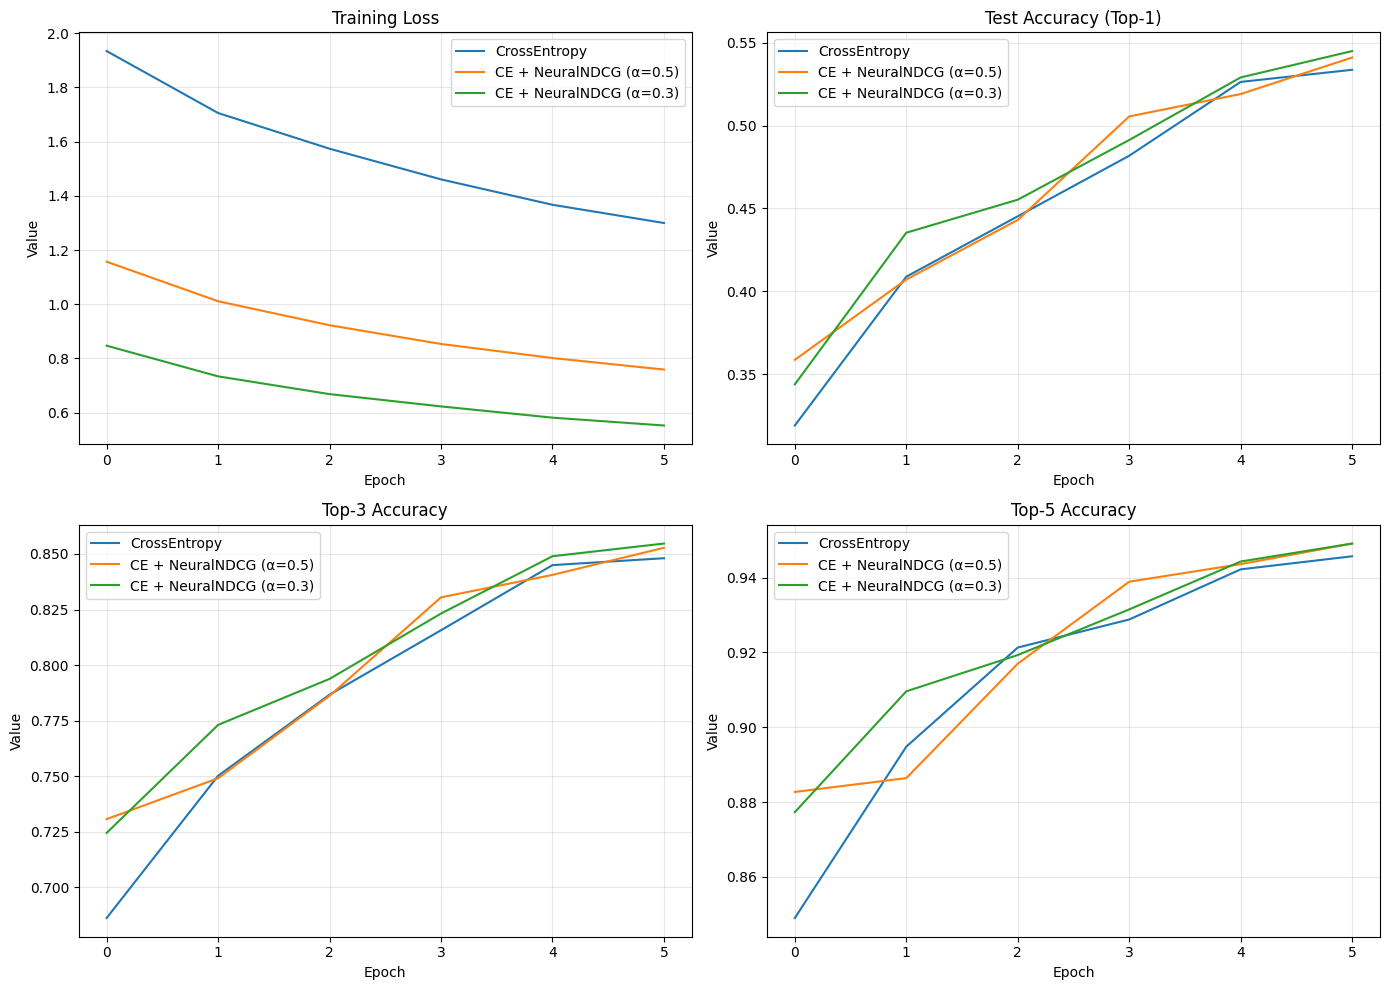

In [5]:
results = {}

print("\n[1/3] CE only...")
_, hist_ce = run_experiment(loss_type='ce', epochs=6)
results['CrossEntropy'] = hist_ce

print("\n[2/3] CE + NeuralNDCG (α=0.5)...")
_, hist_05 = run_experiment(loss_type='combined', epochs=6, alpha=0.5)
results['CE + NeuralNDCG (α=0.5)'] = hist_05

print("\n[3/3] CE + NeuralNDCG (α=0.3)...")
_, hist_03 = run_experiment(loss_type='combined', epochs=6, alpha=0.3)
results['CE + NeuralNDCG (α=0.3)'] = hist_03

print_summary_table(results)
plot_results(results)


Вывод: комбинированный лосс (CE + NeuralNDCG) превосходит только CE по всем метрикам. Оптимальный α зависит от задачи.